In [1]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
X_train = pd.read_csv('data/training_set_features.csv', index_col='respondent_id')
y_train = pd.read_csv('data/training_set_labels.csv', index_col='respondent_id')

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 35 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   h1n1_concern                 26615 non-null  float64
 1   h1n1_knowledge               26591 non-null  float64
 2   behavioral_antiviral_meds    26636 non-null  float64
 3   behavioral_avoidance         26499 non-null  float64
 4   behavioral_face_mask         26688 non-null  float64
 5   behavioral_wash_hands        26665 non-null  float64
 6   behavioral_large_gatherings  26620 non-null  float64
 7   behavioral_outside_home      26625 non-null  float64
 8   behavioral_touch_face        26579 non-null  float64
 9   doctor_recc_h1n1             24547 non-null  float64
 10  doctor_recc_seasonal         24547 non-null  float64
 11  chronic_med_condition        25736 non-null  float64
 12  child_under_6_months         25887 non-null  float64
 13  health_worker   

In [4]:
X_train.isna().sum()

h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
r

There should be 26,707 entries for each column. However, most columns are missing some information and a few columns are missing a significant amount of information. Will inspect those columns and determine if they should be kept or dropped outright.

In [5]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26707 entries, 0 to 26706
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   h1n1_vaccine      26707 non-null  int64
 1   seasonal_vaccine  26707 non-null  int64
dtypes: int64(2)
memory usage: 625.9 KB


In [6]:
y_train.h1n1_vaccine.value_counts(normalize=True)

0    0.787546
1    0.212454
Name: h1n1_vaccine, dtype: float64

In [7]:
y_train.seasonal_vaccine.value_counts(normalize=True)

0    0.534392
1    0.465608
Name: seasonal_vaccine, dtype: float64

There is a significant class imbalance for the H1N1 vaccine and I will have to use SMOTE to fix that later on when building my pipelines to account for this. For seasonal flu vaccines, the classes are more balanced and there is nothing that should be done. There are no missing values in either column.

# EDA

For the columns hhs_geo_region, employment_industry, and employment_occupation the values are represented in a short random string to protect information about the individual. The random character strings are representative of an actual region, industry, and occupation respectively. 

In [8]:
y_train_h1n1 = y_train[['h1n1_vaccine']]
y_train_flu = y_train[['seasonal_vaccine']]

In [9]:
X_train.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


In [10]:
df = X_train.merge(y_train, on = 'respondent_id')

In [11]:
df.head()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,h1n1_vaccine,seasonal_vaccine
respondent_id,,,,,,,,,,,,,,,,,,,,,
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0
1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,...,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,0,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,...,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,0,0
3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,0,1
4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,0,0


## Looking at individual attitudes towards the H1N1 virus and the H1N1 vaccine

[Text(0, 0, 'Not Concerned at All'),
 Text(1, 0, 'Not Very Concerned'),
 Text(2, 0, 'Somewhat Concerned'),
 Text(3, 0, 'Very Concerned')]

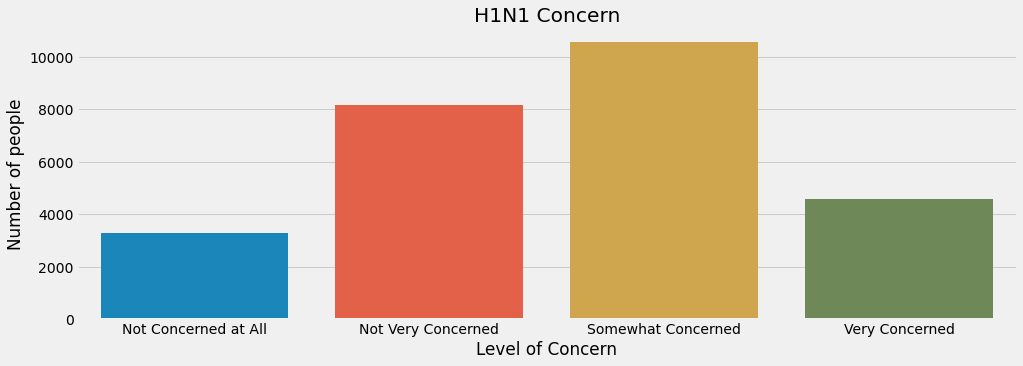

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(df.h1n1_concern)
plt.title('H1N1 Concern')
plt.ylabel('Number of people')
plt.xlabel('Level of Concern')
ax.set_xticklabels(['Not Concerned at All', 'Not Very Concerned',
                    'Somewhat Concerned', 'Very Concerned'])

[Text(0, 0, 'No Knowledge'),
 Text(1, 0, 'A little Knowledge'),
 Text(2, 0, 'A lot of Knowledge')]

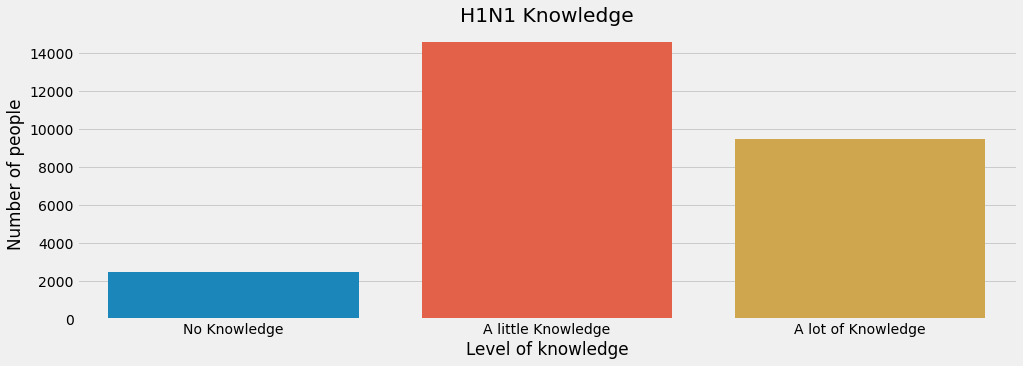

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(df.h1n1_knowledge)
plt.title('H1N1 Knowledge')
plt.ylabel('Number of people')
plt.xlabel('Level of knowledge')
ax.set_xticklabels(
    ['No Knowledge', 'A little Knowledge', 'A lot of Knowledge'])

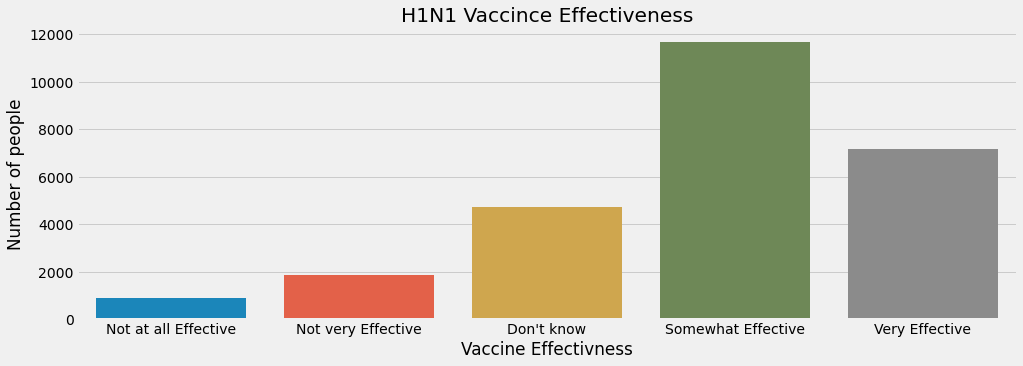

In [14]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(df.opinion_h1n1_vacc_effective)
plt.title('H1N1 Vaccince Effectiveness')
plt.ylabel('Number of people')
plt.xlabel('Vaccine Effectivness')
ax.set_xticklabels(['Not at all Effective', 'Not very Effective',
                    'Don\'t know', 'Somewhat Effective', 'Very Effective']);

Looking at the level of concern that individuals have we can see that most people are at least somewhat concerned or very concerned. Though, there are a substantial group of people who are either not very concerned or not concerned at all about the H1N1 virus. When looking at the level of knowledge of the H1N1 virus we see that a majority of people have at least some knowledge with quite a few people having a lot of knowledge about the virus. Finally, looking at individual's responses about the effectiveness of the H1N1 vaccine we see that most individuals fall between believing that the vaccine is either somewhat effective or very effective. From looking the people's opinions we can see that most people have some knowledge about the virus, however, there is not a large majority of people who are concerned about the H1H1 virus. We do see that most people do believe that the vaccine is somewhat effective. Next, we will look at the concern of the H1N1 virus by race to see if there is a distinction between the different races.

## Looking at H1N1 Concern by Race

In [15]:
df.race.value_counts()

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [16]:
white = df[df.race == 'White']
white_concern = white.h1n1_concern

[Text(0, 0, 'Not Concerned at All'),
 Text(1, 0, 'Not Very Concerned'),
 Text(2, 0, 'Somewhat Concerned'),
 Text(3, 0, 'Very Concerned')]

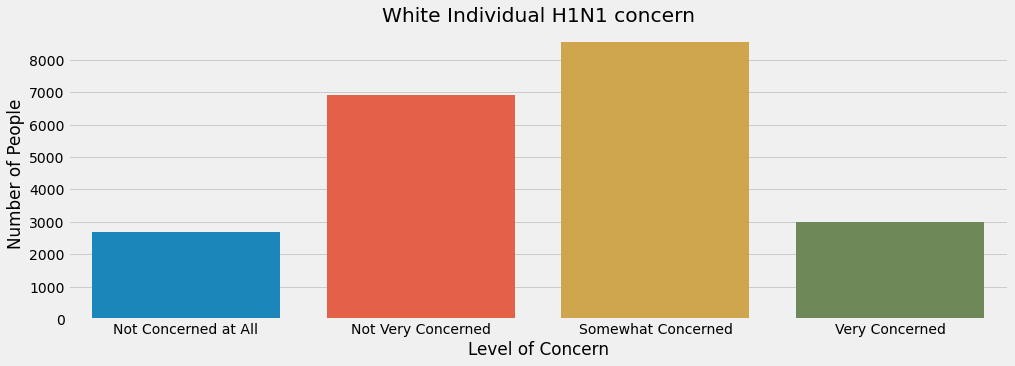

In [17]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(white_concern)
plt.title('White Individual H1N1 concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern')
ax.set_xticklabels(['Not Concerned at All', 'Not Very Concerned',
                    'Somewhat Concerned', 'Very Concerned'])

In [18]:
black = df[df.race == 'Black']
black_concern = black.h1n1_concern

[Text(0, 0, 'Not Concerned at All'),
 Text(1, 0, 'Not Very Concerned'),
 Text(2, 0, 'Somewhat Concerned'),
 Text(3, 0, 'Very Concerned')]

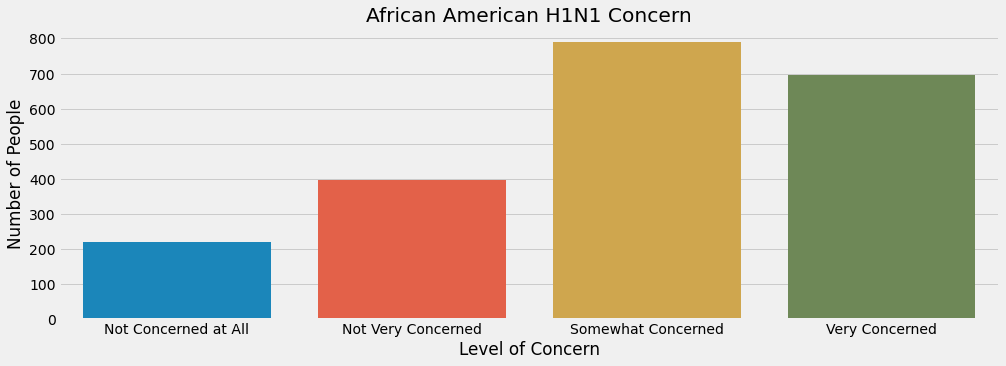

In [19]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(black_concern)
plt.title('African American H1N1 Concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern')
ax.set_xticklabels(['Not Concerned at All', 'Not Very Concerned',
                    'Somewhat Concerned', 'Very Concerned'])

In [20]:
hispanic = df[df.race == 'Hispanic']
hispanic_concern = hispanic.h1n1_concern

[Text(0, 0, 'Not Concerned at All'),
 Text(1, 0, 'Not Very Concerned'),
 Text(2, 0, 'Somewhat Concerned'),
 Text(3, 0, 'Very Concerned')]

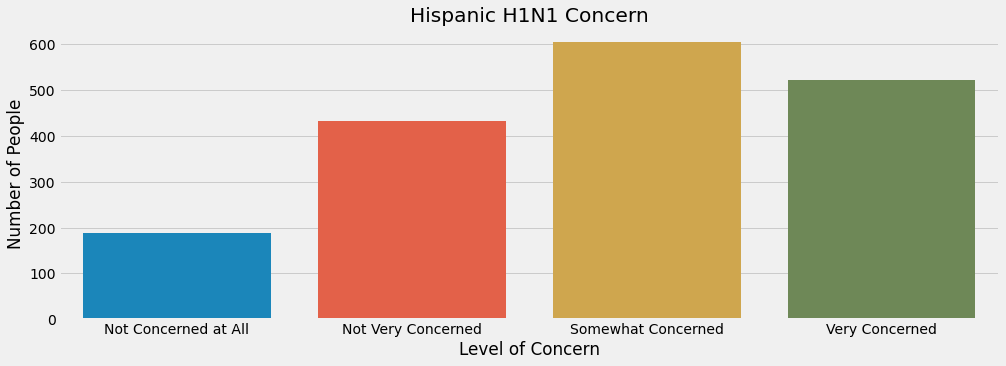

In [21]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(hispanic_concern)
plt.title('Hispanic H1N1 Concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern')
ax.set_xticklabels(['Not Concerned at All', 'Not Very Concerned',
                    'Somewhat Concerned', 'Very Concerned'])

In [22]:
other_multiple = df[df.race == 'Other or Multiple']
other_multiple_concern = other_multiple.h1n1_concern

[Text(0, 0, 'Not Concerned at All'),
 Text(1, 0, 'Not Very Concerned'),
 Text(2, 0, 'Somewhat Concerned'),
 Text(3, 0, 'Very Concerned')]

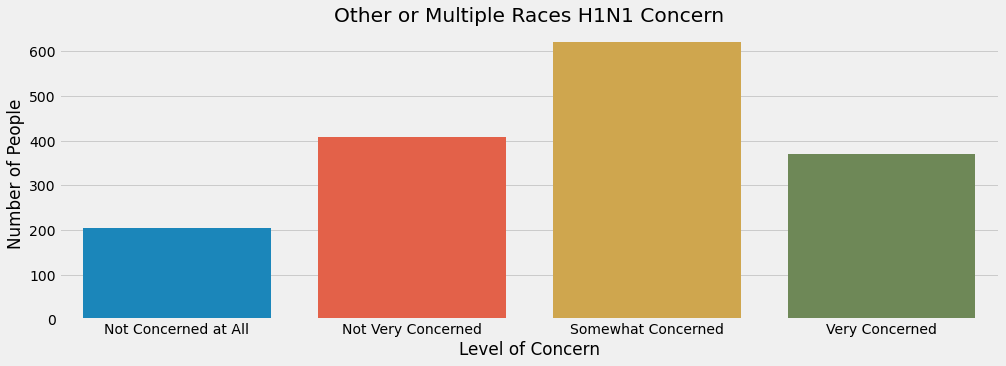

In [23]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.countplot(other_multiple_concern)
plt.title('Other or Multiple Races H1N1 Concern')
plt.ylabel('Number of People')
plt.xlabel('Level of Concern')
ax.set_xticklabels(['Not Concerned at All', 'Not Very Concerned',
                    'Somewhat Concerned', 'Very Concerned'])

When looking at a breakdown of the different races we see that across all of them most people were at least somewhat concerned about the H1N1 virus. Where the differences come out is the next largest level of concern. For People who identify as white, there were a large number of people who are not very concerned about the virus, with not concerned at all, and were very concerned far behind both of the other values. For Black individuals there most people were somewhat concerned followed closely behind with people who were very concerned about this virus. People who were not very or not at all concerned being far behind the other two. When looking at the responses of Hispanic individuals we see that most people are at least somewhat concerned, but that there is also a large number of people who are not very concerned and very concerned. Finally, when looking at other races/multiple races we see that again most people are somewhat concerned, but there are slightly more people who are not very concerned than very concerned. 

## Looking at the level of H1N1 concern and Vaccination status

In [24]:
no_h1n1 = df[df.h1n1_vaccine == 0]
level_concern_no_h1n1 = no_h1n1.h1n1_concern

In [25]:
no_vaccine = level_concern_no_h1n1.value_counts(normalize=True).sort_index()

([<matplotlib.axis.XTick at 0x28d22498d00>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

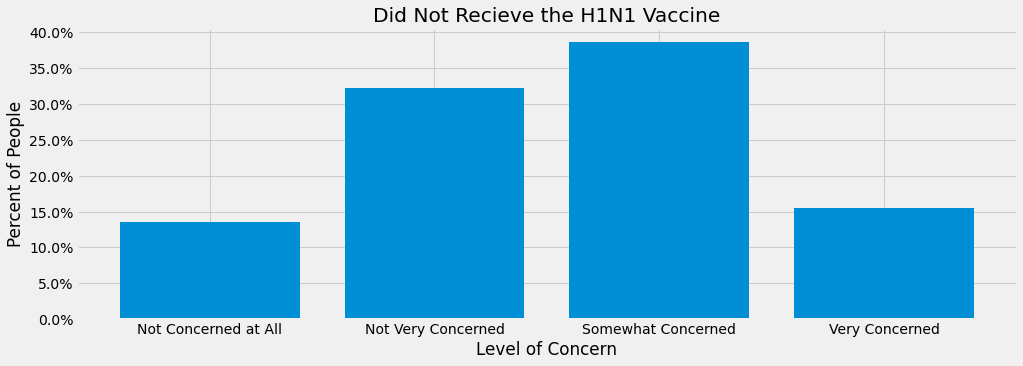

In [26]:
fig, ax = plt.subplots(figsize=(15, 5))
x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']

plt.bar(no_vaccine.index, no_vaccine.values)
plt.title('Did Not Recieve the H1N1 Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

In [27]:
yes_h1h1 = df[df.h1n1_vaccine == 1]
level_concern_yes_h1h1 = yes_h1h1.h1n1_concern
yes_vaccine = level_concern_yes_h1h1.value_counts(normalize=True).sort_index()

([<matplotlib.axis.XTick at 0x28d22503ac0>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

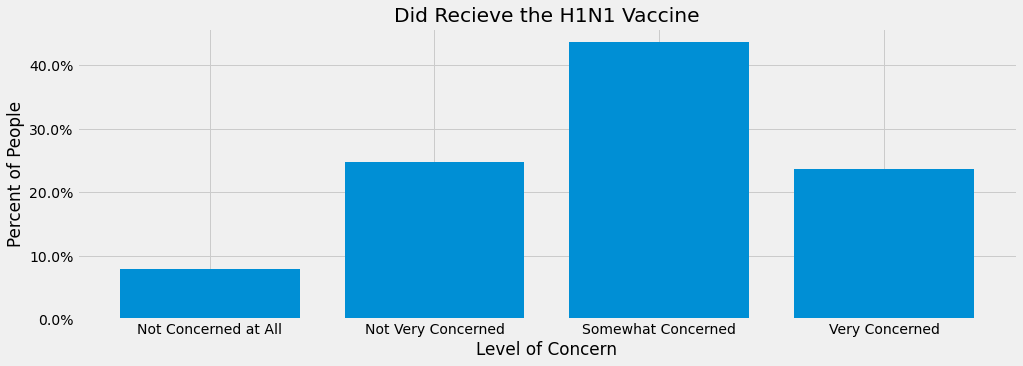

In [28]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']

plt.bar(yes_vaccine.index, yes_vaccine.values)
plt.title('Did Recieve the H1N1 Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

When comparing the vaccination status for H1N1 and the level of concern we find there is a difference between the level of concern of those who did receive the vaccine and those who did not. Looking at those individuals who had did not receive the H1N1 vaccine we see that $13.59%$ had no concern, $32.23%$ had very little concern, $38.66%$ were somewhat concerned and only $15.51%$ were very concerned. Comparing that to those people who did receive the vaccine we see that their rate of concern was $7.90%$, $24.69%$, $43.71%$, and $23.70%$ respectively for each group. For people who received the vaccine, their rate of not being concerned at all was $5.69%$ lower than those who did not receive the vaccine. This makes sense intuitively since people who are not concerned about an illness are less likely to take precautions to prevent or lower their chances of getting severely sick because of that illness. For people who received the vaccine, their rate of not very concerned was $7.54%$ lower than those who did not receive the vaccine. Again, people who are not concerned about an illness are less likely to take a vaccine that will help to prevent serious illness or death against that very illness. Those two groups provide no surprise to the difference between those individuals who were vaccinated and those who were not. Now, if we look at the two groups of people who were at least somewhat concerned we should expect the difference in group sizes to be larger than those who were not vaccinated. Looking first at people who were somewhat concerned we see that this group is $5.05%$ larger than the same group in non-vaccinated people. Finally looking at the difference for people who are very concerned we see that the difference is $8.19%$, the largest of all the groups between vaccinated and non vaccinated people.

### Breakdown by Race

#### White Individuals

In [29]:
white_no_vaccine = white[white.h1n1_vaccine == 0]
white_no_vaccine_concern = white_no_vaccine.h1n1_concern
no_vaccine_white = white_no_vaccine_concern.value_counts(
    normalize=True).sort_index()
no_vaccine_white


0.0    0.139571
1.0    0.345781
2.0    0.390933
3.0    0.123714
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d22ac19a0>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

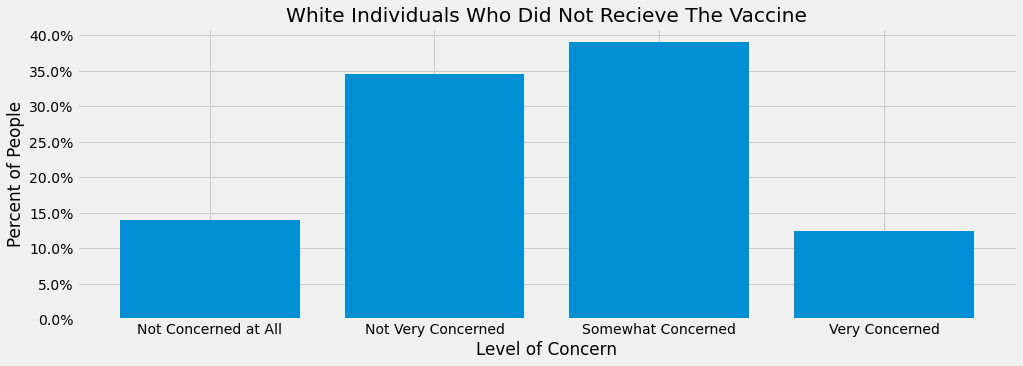

In [30]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(no_vaccine_white.index, no_vaccine_white.values)
plt.title('White Individuals Who Did Not Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

In [31]:
white_yes_vaccine = white[white.h1n1_vaccine == 1]
white_yes_vaccine_concern = white_yes_vaccine.h1n1_concern
yes_vaccine_white = white_yes_vaccine_concern.value_counts(
    normalize=True).sort_index()
yes_vaccine_white

0.0    0.081338
1.0    0.259547
2.0    0.452427
3.0    0.206688
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d22b2a3a0>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

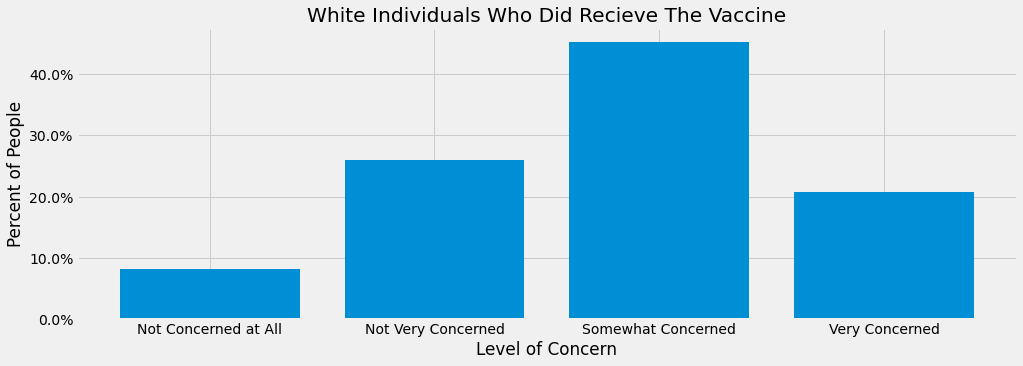

In [32]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(yes_vaccine_white.index, yes_vaccine_white.values)
plt.title('White Individuals Who Did Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

Write Stuff here...

#### Black Individuals

In [33]:
black_no_vaccine = black[black.h1n1_vaccine == 0]
black_no_vaccine_concern = black_no_vaccine.h1n1_concern
black_no_vaccine = black_no_vaccine_concern.value_counts(
    normalize=True).sort_index()
black_no_vaccine

0.0    0.110925
1.0    0.193980
2.0    0.379599
3.0    0.315496
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d257fa1c0>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

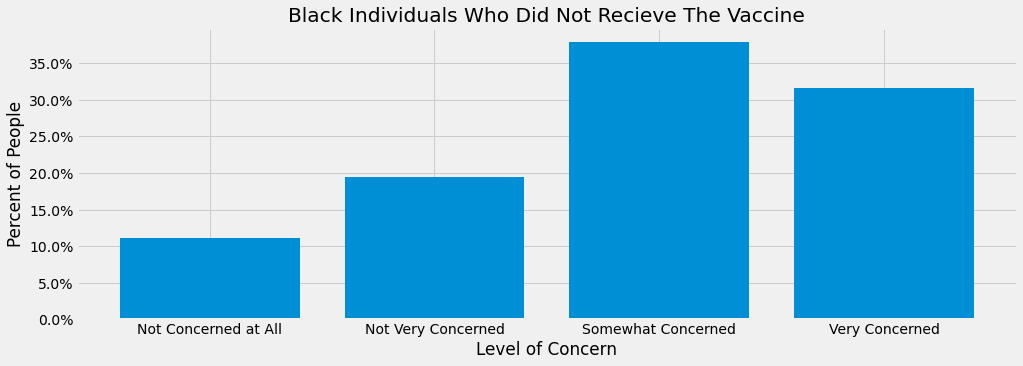

In [34]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(black_no_vaccine.index, black_no_vaccine.values)
plt.title('Black Individuals Who Did Not Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

In [35]:
black_yes_vaccine = black[black.h1n1_vaccine == 1]
black_yes_vaccine_concern = black_yes_vaccine.h1n1_concern
black_yes_vaccine = black_yes_vaccine_concern.value_counts(
    normalize=True).sort_index()
black_yes_vaccine

0.0    0.070513
1.0    0.157051
2.0    0.352564
3.0    0.419872
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d2585d4c0>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

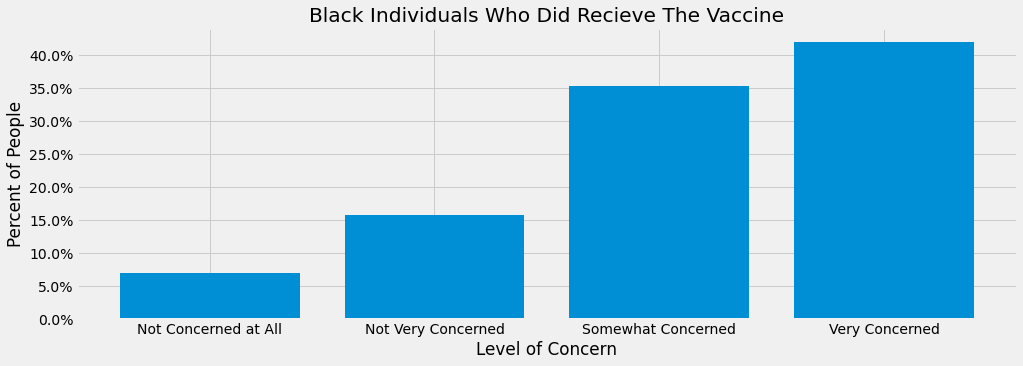

In [36]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(black_yes_vaccine.index, black_yes_vaccine.values)
plt.title('Black Individuals Who Did Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

Write stuff here...

#### Hispanic Individuals

In [37]:
hispanic_no_vaccine = hispanic[hispanic.h1n1_vaccine == 0]
hispanic_no_vaccine_concern = hispanic_no_vaccine.h1n1_concern
hispanic_no_vaccine = hispanic_no_vaccine_concern.value_counts(
    normalize=True).sort_index()
hispanic_no_vaccine

0.0    0.118497
1.0    0.256503
2.0    0.345376
3.0    0.279624
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d258ce100>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

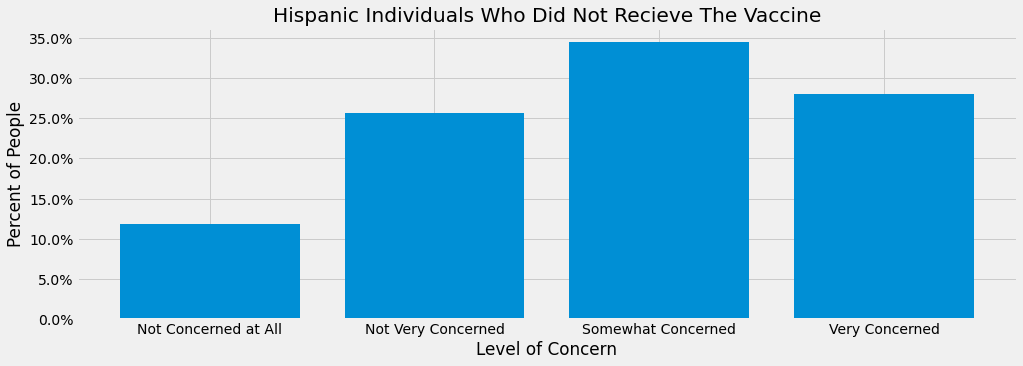

In [38]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(hispanic_no_vaccine.index, hispanic_no_vaccine.values)
plt.title('Hispanic Individuals Who Did Not Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

In [39]:
hispanic_yes_vaccine = hispanic[hispanic.h1n1_vaccine == 1]
hispanic_yes_vaccine_concern = hispanic_yes_vaccine.h1n1_concern
hispanic_yes_vaccine = hispanic_yes_vaccine_concern.value_counts(
    normalize=True).sort_index()
hispanic_yes_vaccine

0.0    0.065934
1.0    0.211538
2.0    0.351648
3.0    0.370879
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d259314f0>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

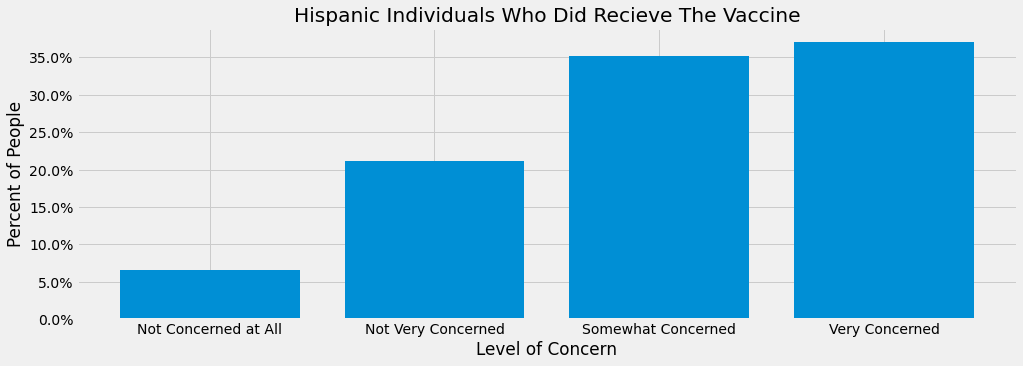

In [40]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(hispanic_yes_vaccine.index, hispanic_yes_vaccine.values)
plt.title('Hispanic Individuals Who Did Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

Write stuff here...


#### Other / Multiple Race Individuals

In [41]:
other_multiple_no_vaccine = other_multiple[other_multiple.h1n1_vaccine == 0]
other_multiple_no_vaccine_concern = other_multiple_no_vaccine.h1n1_concern
other_multiple_no_vaccine = other_multiple_no_vaccine_concern.value_counts(
    normalize=True).sort_index()
other_multiple_no_vaccine

0.0    0.143198
1.0    0.270485
2.0    0.385044
3.0    0.201273
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d25fa1b50>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

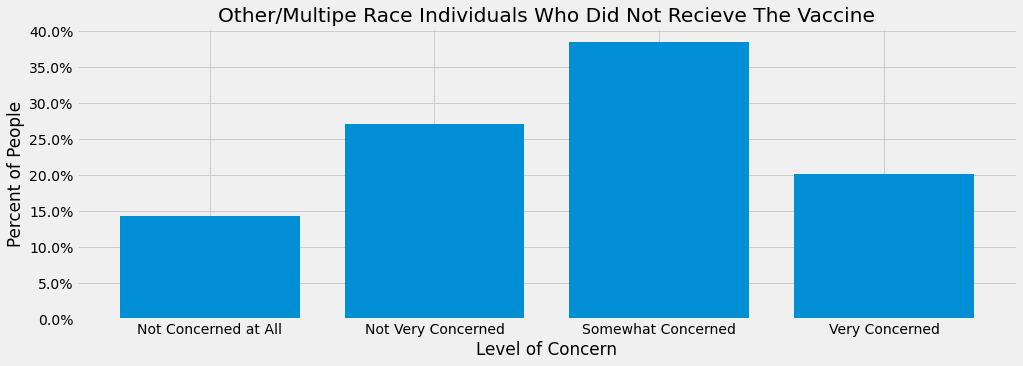

In [42]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(other_multiple_no_vaccine.index, other_multiple_no_vaccine.values)
plt.title('Other/Multipe Race Individuals Who Did Not Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

In [43]:
other_multiple_yes_vaccine = other_multiple[other_multiple.h1n1_vaccine == 1]
other_multiple_yes_vaccine_concern = other_multiple_yes_vaccine.h1n1_concern
other_multiple_yes_vaccine = other_multiple_yes_vaccine_concern.value_counts(
    normalize=True).sort_index()
other_multiple_yes_vaccine

0.0    0.069164
1.0    0.195965
2.0    0.397695
3.0    0.337176
Name: h1n1_concern, dtype: float64

([<matplotlib.axis.XTick at 0x28d213d5430>,
 [Text(0.0, 0, 'Not Concerned at All'),
  Text(1.0, 0, 'Not Very Concerned'),
  Text(2.0, 0, 'Somewhat Concerned'),
  Text(3.0, 0, 'Very Concerned')])

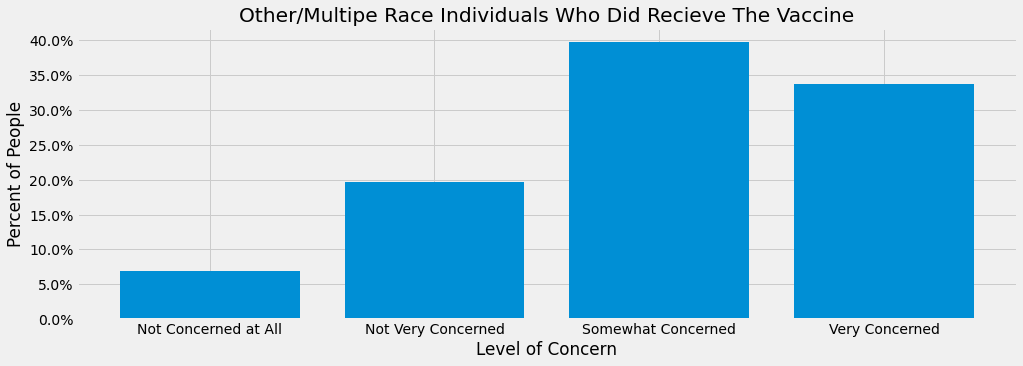

In [44]:
fig, ax = plt.subplots(figsize=(15, 5))

x = ['Not Concerned at All', 'Not Very Concerned',
     'Somewhat Concerned', 'Very Concerned']
plt.bar(other_multiple_yes_vaccine.index, other_multiple_yes_vaccine.values)
plt.title('Other/Multipe Race Individuals Who Did Recieve The Vaccine')
plt.ylabel('Percent of People')
plt.xlabel('Level of Concern')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.xticks(ticks=no_vaccine.index, labels=x)

Write Stuff here...

In [45]:
df.age_group.value_counts(normalize=True).sort_index()

18 - 34 Years    0.195267
35 - 44 Years    0.144082
45 - 54 Years    0.196128
55 - 64 Years    0.208297
65+ Years        0.256225
Name: age_group, dtype: float64